In [ ]:
import os 
import cebra
from cebra import CEBRA
import pandas as pd
import tables
import sys
import matplotlib.pyplot as plt

1. Load all S_aligned files and save them as hdf5

In [ ]:
path = '/Users/annateruel/Desktop/results_calcium/AD22092'

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('S_aligned.csv'):
            file_path = os.path.join(root, file)  # Get the full path to the CSV file
            # Use a key based on the relative path of the CSV file to store it in the dictionary
            key = os.path.relpath(file_path, path).replace('S_aligned.csv', '').replace(os.path.sep, '_')

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            df = df.drop('frame', axis=1)
            df = (df>0).astype(int) #converting all numbers above 0 to 1, so that our spikes are boolean

            # Define the path to save the HDF5 file in the same directory with the same name
            h5_file_path = os.path.splitext(file_path)[0] + '.h5'

            # Save the DataFrame as an HDF5 file in the same directory
            df.to_hdf(h5_file_path, key='data', mode='w')
            
            print(f"Converted '{file}' to '{os.path.basename(h5_file_path)}' and saved in '{os.path.dirname(h5_file_path)}'")

2. Create a dictionary storing info from 4 different hdf5 files. Each file belongs to a different session. Total number of sessions: 4. 

In [ ]:
import numpy as np
t = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22118/session2/S_aligned.h5')
t

In [ ]:
b = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session2/centroid.h5')
b

In [ ]:
path = '/Users/annateruel/Desktop/results_calcium/AD22118'
data = {}  # Create a dictionary to store data from each CSV file

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('S_aligned.csv'):
            file_path = os.path.join(root, file)  # Get the full path to the CSV file
            # Use a key based on the relative path of the CSV file to store it in the dictionary
            key = os.path.relpath(file_path, path).replace('S_aligned.csv', '').replace(os.path.sep, '_')
            data[key] = pd.read_csv(file_path)


In [ ]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22092/session2/S_aligned.h5')
b = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22092/session2/centroid.h5')



### CEBRA-time 
Uses time without behaviour information

In [ ]:
max_iterations = 10000 

cebra_time_model = CEBRA(model_architecture='offset10-model',  #CEBRA TIME model
                        batch_size=512,
                        learning_rate=0.05,
                        temperature=1.12,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='mps',
                        verbose=True,
                        time_offsets=10)

In [ ]:
cebra_time_model.fit(nd) #training
cebra_time_model.save("cebra_time_model_ad22092_s4.pt")

In [ ]:
cebra_time_model = cebra.CEBRA.load("cebra_time_model_ad22092_s2.pt")
cebra_time = cebra_time_model.transform(nd)

In [ ]:
cebra.plot_embedding(embedding=cebra_time, embedding_labels=b[:,0], title='CEBRA-Behavior_s1', cmap='cebra', dpi = 200, markersize= 1)

In [ ]:
fig = plt.figure(figsize=(20,5))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_time, embedding_labels=nd_s4[:,4], title='CEBRA-Time Session4')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_time, embedding_labels=nd_s4[:,50], title='CEBRA-Time Session4')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_time, embedding_labels=nd_s4[:,1], title='CEBRA-Time Session4')




### CEBRA-behavior

Train a model that uses positional (pose estimation) information

Now we
 want to run CEBRA BEHAVIOR, thus we need to use as labels our behavior from dlc, which are different h5 files. To do so, we need to merge with `pd.merge` all h5 files from dlc, because since during the recoridng we save a video every 1000 frames, we need to get one single file.

In [ ]:
h5_dir = '/Volumes/ANNA_HD/ANALYSIS/minian/AD22-118/'

for session_dir in os.listdir(h5_dir):
    session_path = os.path.join(h5_dir, session_dir)
    
    # Check if the item in the root directory is a directory itself
    if os.path.isdir(session_path):
        dlc_output_dir = os.path.join(session_path, 'dlc')  # Path to "dlc" output directory
        
        if os.path.exists(dlc_output_dir) and os.path.isdir(dlc_output_dir):
            # Initialize an empty list to store DataFrames for this session
            dataframes = []
            
            # Loop through h5 files in the "dlc" output directory
            for h5_file in os.listdir(dlc_output_dir):
                if h5_file.startswith("._"):
                    file_path = os.path.join(dlc_output_dir, h5_file)
                    os.remove(file_path)
                elif h5_file.endswith('filtered.h5'):
                    h5_file_path = os.path.join(dlc_output_dir, h5_file)

                    # Read the h5 file into a DataFrame
                    df = pd.read_hdf(h5_file_path)
                    # Append the DataFrame to the list
                    dataframes.append(df)
            
            if dataframes:
                # Merge all DataFrames in this session into a single DataFrame
                merged_df = pd.concat(dataframes, axis=0)
                
                # Define the path to save the merged h5 file in the session directory
                output_h5_path = os.path.join(session_path, 'merged_output.h5')
                
                # Save the merged DataFrame as an h5 file
                merged_df.to_hdf(output_h5_path, key='data', mode='w')
                
                print(f"Merged data saved to '{output_h5_path}' in session '{session_dir}'")
        



Calculate the centroid, to use centroid position in space as your label, because we're interested in position among space. 

In [ ]:
behavior = pd.read_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session1/merged_output.h5')
df = behavior.loc[:,('DLC_resnet50_ca2+imgJan30shuffle1_500000')]
df['x_centroid'] = np.mean(df.loc[:,(slice(None), 'x')], axis=1)
df['y_centroid'] = np.mean(df.loc[:,(slice(None), 'y')], axis=1)
df2 = df[['x_centroid', 'y_centroid']]
df2.to_hdf('/Users/annateruel/Desktop/results_calcium/AD22092/session1/centroid.h5', key='data', mode='w')

In [106]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/phd_code/cebra/AD22118/session4/S_aligned.h5')
b = cebra.load_data(file='/Users/annateruel/phd_code/cebra/AD22118/session4/centroid.h5')


'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [ ]:
max_iterations = 10000 

cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=0.05,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='mps',
                        verbose=True,
                        time_offsets=10)

In [ ]:
cebra_behavior_model.fit(nd, b)
cebra_behavior_model.save("cebra_behavior_model_ad22092_s4.pt")


In [111]:
cebra_behavior_model = cebra.CEBRA.load('/Users/annateruel/phd_code/cebra/AD22118/cebra_behavior_model_ad22118_s4.pt')
cebra_behavior = cebra_behavior_model.transform(nd)

In [102]:
# Define the centers and radii for the new ROIs
roi9_center = (194, 438)
roi9_radius = 52

roi10_center = (195, 200)
roi10_radius = 46

# Function to check if a point is in a circle
def is_point_in_circle(point_x, point_y, circle_center, radius):
    return (point_x - circle_center[0])**2 + (point_y - circle_center[1])**2 <= radius**2

In [112]:
x_coords = b[:,0] # Adjust 'x' to the actual column name if different
y_coords = b[:,1]  # Adjust 'y' to the actual column name if different

In [113]:
in_roi1 = [is_point_in_circle(x, y, roi1_center, roi1_radius) for x, y in zip(x_coords, y_coords)]
in_roi2 = [is_point_in_circle(x, y, roi2_center, roi2_radius) for x, y in zip(x_coords, y_coords)]

# Boolean array where True indicates the timestamp is inside either ROI
in_any_roi = np.logical_or(in_roi1, in_roi2)

# Filter embedding points
filtered_points = cebra_behavior[in_any_roi]

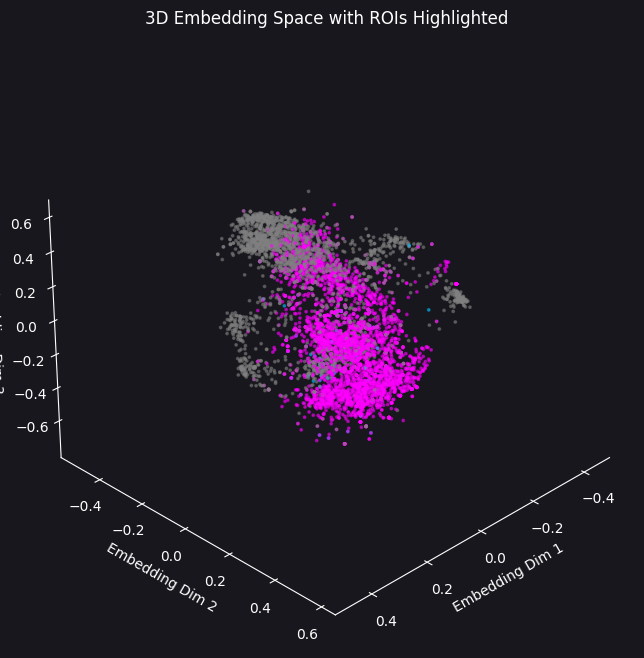

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Set up the plot with 3D projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x = cebra_behavior[:, 0]
y = cebra_behavior[:, 1]
z = cebra_behavior[:, 2]  # Assuming your embedding has a third dimension

# Initialize an empty list for colors
colors = ['gray'] * len(cebra_behavior)  # Use a list for color assignment

# Assign 'deepskyblue' to points in ROI 1
for idx, in_roi in enumerate(in_roi1):
    if in_roi:
        colors[idx] = 'deepskyblue'

# Assign 'magenta' to points in ROI 2
for idx, in_roi in enumerate(in_roi2):
    if in_roi:
        colors[idx] = 'magenta'

# Plot using the colors array
scatter = ax.scatter(x, y, z, c=colors, alpha=0.5, s=3)

# Rotate the view
ax.view_init(elev=30, azim=45)  # Adjust elevation and azimuth for desired perspective

# Remove background features
ax.grid(False)  # Turn off the grid
ax.xaxis.pane.fill = False  # Remove the background pane
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')  # Set edges to white or turn off visibility
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.xaxis.pane.set_alpha(0)  # Make panes transparent
ax.yaxis.pane.set_alpha(0)
ax.zaxis.pane.set_alpha(0)

# Set the background color of the figure (outside the axes) using the specific code
fig.patch.set_facecolor('#17171D')

# Set the background color of the axes (area around the scatter plot) using the specific code
ax.set_facecolor('#17171D')

plt.title('3D Embedding Space with ROIs Highlighted')
ax.set_xlabel('Embedding Dim 1')
ax.set_ylabel('Embedding Dim 2')
ax.set_zlabel('Embedding Dim 3')

# Save the figure with the same background color as shown
plt.savefig('embedding_space_with_rois.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()


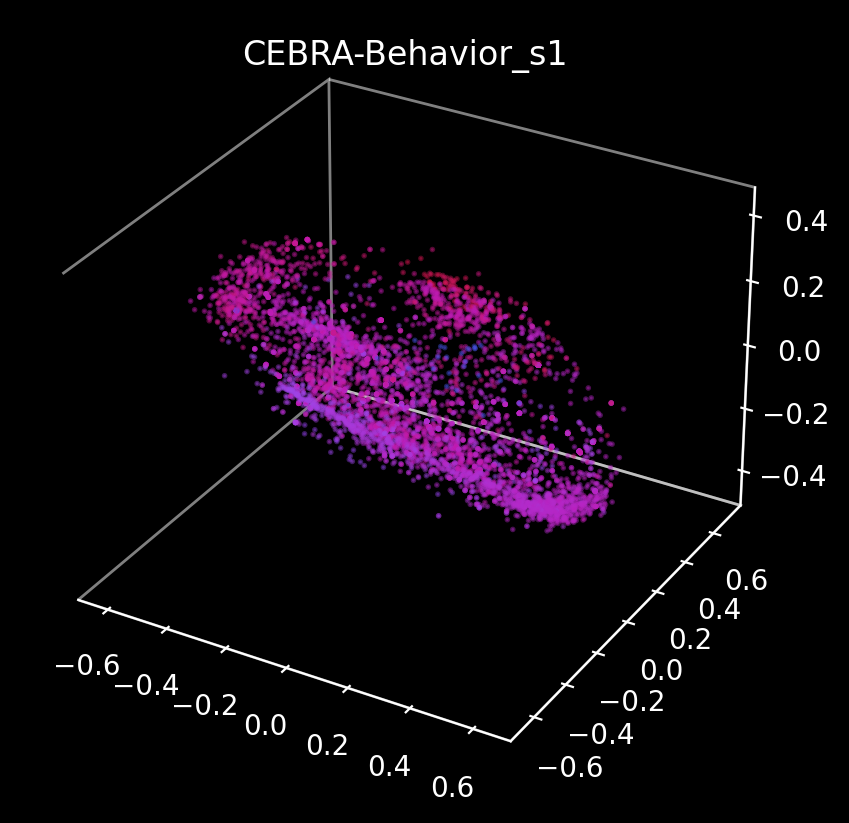

In [14]:
plt.style.use('dark_background')  # plots with black background
cebra.plot_embedding(embedding=cebra_behavior, embedding_labels=b[:,0], title='CEBRA-Behavior_s1', cmap='cebra', dpi = 200, markersize= 1)
#plt.savefig('/Users/annateruel/Desktop/s2.svg', format='png')

Visualize the data: behavior and neural activity 

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(nd.T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), b[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.show()

In [ ]:
import os
import numpy as np
dir = '/Users/annateruel/phd_code/cebra/AD22118/'
file_list = [files for files in os.listdir(dir) if files.endswith('.pt')]
file_list = np.sort(file_list)
file_list

In [ ]:
root_directory = '/Users/annateruel/phd_code/cebra/AD22118/'
file_directories = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file == 'S_aligned.h5':
            # Append the directory path to the list
            file_path = os.path.join(root, file)
            file_directories.append(file_path)
calcium_file = np.sort(file_directories)
calcium_file 

root_directory = '/Users/annateruel/phd_code/cebra/AD22118/'
file_directories = []
for root, dirs, files in os.walk(root_directory):
    for file in files:
        if file == 'centroid.h5':
            # Append the directory path to the list
            file_path = os.path.join(root, file)
            file_directories.append(file_path)
beh_file = np.sort(file_directories)
beh_file 

In [ ]:
plt.style.use('dark_background')  # plots with black background
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

for session, dataset, dataset2, ax in zip(file_list, calcium_file, beh_file, axs_up):
    nd = cebra.load_data(file=dataset)
    b =  cebra.load_data(file=dataset2)

    cebra_behavior_model = cebra.CEBRA.load(session)
    embedding = cebra_behavior_model.transform(nd)

    ax=cebra.plot_embedding(ax=ax, embedding=embedding, embedding_labels=b[:,0], title=f"{session}", cmap='cebra', dpi = 100, idx_order=(1, 0, 2), figsize= (3, 3))
    plt.savefig('/Users/annateruel/Desktop/ad22118.pdf', format='pdf')

In [ ]:
embeddings_list = []
labels = []

for session, dataset, dataset2 in zip(file_list, calcium_file, beh_file):
    nd = cebra.load_data(file=dataset)
    b = cebra.load_data(file=dataset2)

    cebra_behavior_model = cebra.CEBRA.load(session)
    cebra_behavior_embedding = cebra_behavior_model.transform(nd)

    # Append the embedding to the list
    embeddings_list.append(cebra_behavior_embedding)
    labels.append(b[:,0])



In [ ]:
for i in range(4):
    if len(embeddings_list[i]) == len(labels[i]):
        print(True)
    else: 
        print(False)


In [ ]:
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=[embeddings_list[0], embeddings_list[1]],
                                                                                       labels=[labels[0], labels[1]],
                                                                                       between="datasets")

In [ ]:
import os
import matplotlib.pyplot as plt
import cebra

plt.style.use('dark_background')  # plots with black background

# Directory containing the files
directory = '/Users/annateruel/phd_code/cebra/AD22118/'

# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Check if the filename matches the structure
    if filename.startswith("cebra_behavior_model_") and filename.endswith(".pt"):
        # Load the model
        cebra_behavior_model = cebra.CEBRA.load(os.path.join(directory, filename))

        # Transform the model and save it as an embedding
        embedding = cebra_behavior_model.transform(nd)

        # Create a new figure for each file
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the embedding
        ax = cebra.plot_embedding(ax=ax, embedding=embedding, embedding_labels=b[:,0], title=f"{filename}", cmap='cebra', dpi = 100, idx_order=(1, 0, 2), figsize= (3, 3))

        # Save the figure
        plt.savefig(f'/Users/annateruel/Desktop/{filename}.pdf', format='pdf')

        # Close the figure to free up memory
        plt.close(fig)

### CEBRA-hybrid

Uses both time and positional information

In [ ]:
import numpy as np
nd = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22118/session4/S_aligned.h5')
b = cebra.load_data(file='/Users/annateruel/Desktop/results_calcium/AD22118/session4/centroid.h5')

In [ ]:
max_iterations = 5000
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=0.05,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='mps',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [ ]:
cebra_hybrid_model.fit(nd, b)
cebra_hybrid_model.save("cebra_hybrid_model_s4.pt")

In [ ]:
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt")
cebra_hybrid = cebra_hybrid_model.transform(nd)


In [ ]:
cebra.plot_embedding(ax=ax1, embedding=cebra_behavior, embedding_labels=b_s4[:,1], title='CEBRA-Behavior Session1', cmap='plasma')
plt.savefig('/Users/annateruel/Desktop/your_plot.svg', format='svg')

### Grid search (hyperparameter tuning)

A grid-search is the process of performing hyperparameter tuning in order to determine the optimal values of a given model. Practically, it consists in running a model on the data, by modifying the hyperparameters values at each iteration. Then, evaluating the performances of each model allows the user to select the best set of hyperparameters for its specific data.


In [ ]:
import cebra
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension = [3,16],
    learning_rate = [0.005, 0.01, 0.05],
    time_offsets = 5,
    max_iterations = 500,
    device='mps',
    temperature_mode = "auto",
    verbose = False)

In [ ]:
datasets = {"dataset1": nd,                     
            "dataset2": (nd, b)} 

In [ ]:
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models")

In [ ]:
df_results = grid_search.get_df_results(models_dir="saved_models2")
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset2", models_dir="saved_models2")
best_model_name